# Swinging on Pitches Outside the Strike Zone

Astrid figured this one out!

```python
dfc["ruth"] = dfc["pitcher_ruthlessness"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["mox"] = dfc["batter_moxie"] * (1+0.2*dfc["batter_vibes"])
dfc["path"] = dfc["batter_patheticism"]  # no vibes here for some reason

dfc["ruth_scaled"] = dfc["ruth"] * dfc["pitcher_multiplier"]
dfc["mox_scaled"] = dfc["mox"] * dfc["batter_multiplier"]
dfc["path_scaled"] = dfc["path"] / dfc["batter_multiplier"]


dfc["combined"] = (12 * dfc["ruth_scaled"]
                   - 5 * dfc["mox_scaled"]
                   + 5 * dfc["path_scaled"]
                   + 4 * dfc["ballpark_viscosity"]  # not centered around 0.5!
                  ) / 20
dfc["combined_pow"] = dfc["combined"] ** 1.5

# any negative values of "combined" will become nan in "combined_pow"!!!
# these will always give a negative result; i.e. no swing.
# This happens when the batter's moxie is much higher than the other factors,
# so I guess it's "perfect pitch vision" because they'll never swing at balls.

dfc["threshold"] = dfc["combined_pow"]
# minimum 0.1, maximum 0.95. The only exception to the minimum is the aforementioned
# nan results for negative "combined".
dfc.loc[dfc["threshold"] > 0.95, "threshold"] = 0.95
dfc.loc[dfc["threshold"] < 0.10, "threshold"] = 0.10
```

Or, together,
```python
dfc["threshold"] = (
    (
        12 * dfc["ruth_scaled"]
        - 5 * dfc["mox_scaled"]
        + 5 * dfc["path_scaled"]
        + 4 * dfc["ballpark_viscosity"]
    )
    / 20
) ** 1.5
dfc.loc[dfc["threshold"] > 0.95, "threshold"] = 0.95
dfc.loc[dfc["threshold"] < 0.10, "threshold"] = 0.10
```

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from csv_dtypes import column_dtypes

import load

In [363]:
season = 18
df = load.data("swing-on-ball", season=season)

df["ruth_vibes"] = load.player_attribute(df, 'pitcher', 'ruthlessness', vibes=True, mods=True, items=True, broken_items=True)
df["cold_vibes"] = load.player_attribute(df, 'pitcher', 'coldness', vibes=True, mods=True, items=True, broken_items=True)

df["mox_vibes"] = load.player_attribute(df, 'batter', 'moxie', vibes=True, mods=True, items=True, broken_items=True)
df["mox_scaled"] = load.player_attribute(df, 'batter', 'moxie', vibes=False, mods=True, items=True, broken_items=True)

df["path_scaled"] = load.player_attribute(df, 'batter', 'patheticism', vibes=False, mods="negative", items="negative", broken_items=True)
df["path_vibes"] = df["path_scaled"] * (1 + 0.2 * df["batter_vibes"])


# center=True is the default
df["viscosity"] = load.stadium_attribute(df, 'viscosity', center=False)
print(len(df))

72979


In [1062]:
dfc = df.copy()
# dfc = dfc[dfc["is_strike"] == True]
# dfc = dfc[dfc["stadium_id"].isna()]
# dfc = dfc[~((dfc["season"] == 11) & (dfc["day"] == 98))] # bad data here

# for exclude_mod in ["GROWTH", "TRAVELING", "SHELLED", "CHUNKY", "SMOOTH", "ON_FIRE", "SPICY"]:
for exclude_mod in ["PSYCHIC", "LATE_TO_PARTY", "ON_FIRE", "CHUNKY", "SMOOTH", "GROWTH", "MINIMALIST", "MAXIMALIST",
                "SINKING_SHIP", "TRAVELING", "HIGH_PRESSURE", "OVERPERFORMING", "UNDERPERFORMING",]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

dfc = dfc[~(dfc["batting_team_mods"].astype(str).str.contains("O_NO") & (dfc["ball_count"] == 0))]
# dfc = dfc[(dfc["pitcher_multiplier"] == 1) & (dfc["batter_multiplier"] == 1)]
dfc = dfc[(dfc["pitching_team_hype"] == 0) & (dfc["batting_team_hype"] == 0)]

# dfc = dfc[dfc["roll"] > 0.1]


len(dfc)

8525

In [1063]:
dfc.loc[dfc["passed"], "roll"].max()

0.4703560853969881

In [1064]:
dfc.loc[~dfc["passed"], "roll"].min()

0.0021673330082327

In [1065]:
# dfc["ruth"] = dfc["pitcher_ruthlessness"] * (1 + 0.2*dfc["pitcher_vibes"])# * df["pitcher_multiplier"]
# dfc["mox"] = dfc["batter_moxie"] * (1+0.2*dfc["batter_vibes"])
# dfc["path"] = dfc["batter_patheticism"]# * (1+0.2*dfc["batter_vibes"])

# dfc["ruth_scaled"] = dfc["ruth"] * dfc["pitcher_multiplier"]
# dfc["mox_scaled"] = dfc["mox"] * dfc["batter_multiplier"]
# dfc["path_scaled"] = dfc["path"] / dfc["batter_multiplier"]

# idea: assume that mox, path are -/+ 0.25, and visc is +0.2, and their sum raised to the 1.5 power


dfc["roll_pow"] = (dfc["roll"] - 0)**(1/1.5) - (0.25*dfc["path_scaled"] - 0.25*dfc["mox_vibes"] + 0.20*dfc["viscosity"])
dfc["roll_pow_2"] = (dfc["roll"] - 0)**(1/1.5) - (0.375*(dfc["ruth_vibes"]**0.4))
dfc["roll_mod"] = dfc["roll"] - (0.25*dfc["path_scaled"] - 0.25*dfc["mox_vibes"] + 0.20*dfc["viscosity"])
dfc["roll_log"] = np.log(dfc["roll_pow"])

dfc["ruth_pow"] = dfc["ruth_vibes"]**(0.25)
dfc["ruth_log"] = np.log(dfc["ruth_vibes"])


# dfc["combined"] = (dfc["ruth_vibes"]*12 - 5*dfc["mox_vibes"]
#                    + 5*dfc["path_scaled"] + 4*dfc["viscosity"]) / 20
dfc["combined"] = (0.375*dfc["ruth_vibes"]**0.25 - 0.25*dfc["mox_vibes"]
                   + 0.25*dfc["path_scaled"] + 0.2*dfc["viscosity"])
dfc["combined_pow"] = dfc["combined"] ** 1.5
# dfc["combined_log"] = np.log(dfc["combined"])
# dfc = dfc[~dfc["combined_pow"].isna()]
dfc = dfc[~dfc["roll_log"].isna()]
len(dfc)

/Users/robbyblum/opt/anaconda3/envs/py3.9/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


8431

In [1067]:
X = dfc[
    [
        "roll",
        # "roll_pow",
        # "roll_log",
        "passed",
        # "combined",
        "combined_pow",
        # "ruth_pow",
        # "ruth_log",
        # "mox_vibes",
        # "path_scaled",
        # "path_vibes",
        # "viscosity",
    ]
].copy()
# X = X[X['roll_pow'] < 0.9]
# X = X[X['roll_pow'] > 0.2]
# X["roll"] = (X["roll"] - 0.05)**(1/1.4)
# X = X[~X["roll_log"].isna()]
# X = X[X["roll"] < 0.95]
X = X[X["roll"] > 0.1]
# X = X.drop("roll", axis=1)
X = X[~X["combined_pow"].isna()]


y = X["passed"]
X = X.drop(["passed"], axis=1)


pin_intercept = None
# pin_intercept = np.log(0.375)
pins = [
    # (0.12, "ruth_vibes"),
    # (3/8, "ruth_pow"),
    # (0.25, "ruth_log"),
    # (0.2, "viscosity"),
    # (-0.25, "mox_vibes"),
    # (0.25, "path_scaled"),
    # (1.0, "combined_pow"),
    
    # (0.07, "hypediff_bvibes"),
    # (-0.04, "hypediff_pvibes"),
]
for val, var in pins:
    X["roll_log"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]
    
print(X.shape)

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=10000000, fit_intercept=pin_intercept is None,
                           tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
sc.inverse_transform(trainedsvm.coef_)
trainedsvm.coef_
sc.scale_
trainedsvm.score(X2, y)
print(f"score: {trainedsvm.score(X2, y)} ({len(X2) - sum(np.diag(confusion_matrix(y, predictionsvm)))} outliers)")

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

print(intercept_scaled, ", intercept")
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if "roll" not in pair[1]:
        print(pair)

(7629, 2)
[[6763    3]
 [   6  857]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      6766
        True       1.00      0.99      0.99       863

    accuracy                           1.00      7629
   macro avg       1.00      1.00      1.00      7629
weighted avg       1.00      1.00      1.00      7629

score: 0.9988202909948879 (9 outliers)
0.00019223436926732608 , intercept
(0.9990884238694401, 'combined_pow')


In [1068]:

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if "roll" not in pair[1]:
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]

dfc["svc"] = dfc["threshold"]
# dfc["threshold"] = dfc["combined_pow"].copy()
# dfc.loc[dfc["threshold"] > 0.95, "threshold"] = 0.95
# dfc.loc[dfc["threshold"] < 0.10, "threshold"] = 0.10

intercept: 0.00019223436926732608
(0.9990884238694401, 'combined_pow')


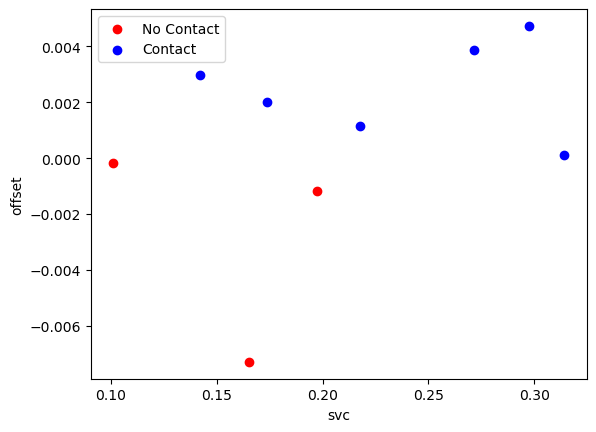

In [1070]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
outliers = outliers[outliers["roll"] > 0.1]

fig, ax = plt.subplots(1)
x_val = "ruth_vibes"
x_val = "svc"
y_val = "offset"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]][y_val],
    color="red",
    label="No Contact",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]][y_val],
    color="blue",
    label="Contact",
)
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

In [1071]:
pd.set_option("display.max_columns", None)
table = outliers[
    [
        "passed",
        "offset",
        # "event_type",
        # "weather",
        # "roll",
        "roll",
        "threshold",
        # "ruth",
        "ruth_vibes",
        "combined",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
        # "batter_vibes"
    ]
]
print(len(table))
table.sort_values("offset", ascending=False)

9


,passed,offset,roll,threshold,ruth_vibes,combined,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,season,day,game_id,play_count
27586,True,0.004736,0.302395,0.297659,0.585705,0.445885,Ayanna Dumpington,Patchwork Southwick,,PRO_SKATER,AMBUSH;FIREPROOF;SEALANT;FIERY,BOTTOM_DWELLER;BLACKHOLE_PAYOUTS,18,35,14790ba3-f7e7-4911-9a70-42398c2ab4fc,183
13092,True,0.003862,0.275245,0.271383,1.357637,0.419225,Stephanie Winters,Uncle Plasma,,EGO1;HARD_BOILED,,,18,19,f5fd1c0d-3bb2-43eb-a8ca-ccb4b676a513,58
9569,True,0.002964,0.144798,0.141833,0.584253,0.271888,Bees Taswell,Eizabeth Elliott,SOUNDPROOF;AMBITIOUS,,MAINTENANCE_MODE;STALEPOPCORN_PAYOUTS,O_NO,18,15,f3d70fbf-6ad4-44ef-bbaa-411ce5ece309,204
5474,True,0.002021,0.175949,0.173928,0.605052,0.311547,Wichita Toaster,Patchwork Southwick,,PRO_SKATER,,BOTTOM_DWELLER;BLACKHOLE_PAYOUTS,18,11,ce153e08-4c3b-4648-9b8f-1fbb2762234d,101
534,True,0.001156,0.218968,0.217811,0.672775,0.362017,Zion Aliciakeyes,Rivers Rosa,GRAVITY;SWIM_BLADDER,,AMBUSH;FIREPROOF;SEALANT;FIERY,BOTTOM_DWELLER;BLACKHOLE_PAYOUTS,18,6,9ca61d1a-e512-4cdf-803d-97d901b8df5e,162
1485,True,0.000121,0.314332,0.314211,1.183028,0.462276,Bobbin Moss,Jayden Wright,,,LIFE_OF_PARTY;ELECTRIC,BASE_INSTINCTS;ELECTRIC,18,7,8bd8f41c-cb1d-4585-9d1c-1603900b6b0d,127
29948,False,-0.000162,0.100912,0.101074,0.886449,0.216840,Rat Mason,Inky Rutledge,EGO1;UNCERTAIN,CAREFUL,ACIDIC;SUN2_PAYOUTS;SUN_KISSED,POPCORN_PAYOUTS,18,38,90c666f3-25e2-450b-b0b4-e0b031e655b8,13
22718,False,-0.001172,0.196223,0.197395,0.401057,0.339005,Felix Garbage,Nolanestophia Patterson,GRAVITY,,ACIDIC;SUN2_PAYOUTS;SUN_KISSED,SHAME_GIVER,18,30,2b5f75a8-69f9-4c85-8ccd-e78232188a51,178
40075,False,-0.007296,0.158020,0.165316,0.323769,0.301164,Sparks Beans,Zephyr McCloud,,TRIPLE_THREAT,SHAME_GIVER,AAA,18,48,9cf03bbf-32fd-4ac5-93fa-31551fe6068b,116


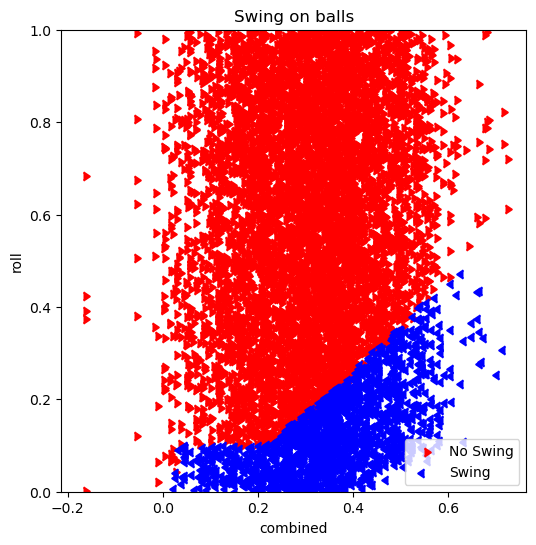

In [1086]:
x_val = "combined"
y_val = "roll"
fig, ax = plt.subplots(1, figsize=(6, 6))

ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="No Swing",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Swing",
    marker=CARETLEFTBASE,
)

ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.set_title(f"Swing on balls")
# ax.set_ylim(0, 1)
if x_val == "threshold" or x_val == "svc":
    ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend(loc="lower right")
ax.set_ylim(0, 1.0)
# ax.set_xlim(-0.05, 0.05)
fig.savefig("../figures/swing_balls.png", facecolor="white")

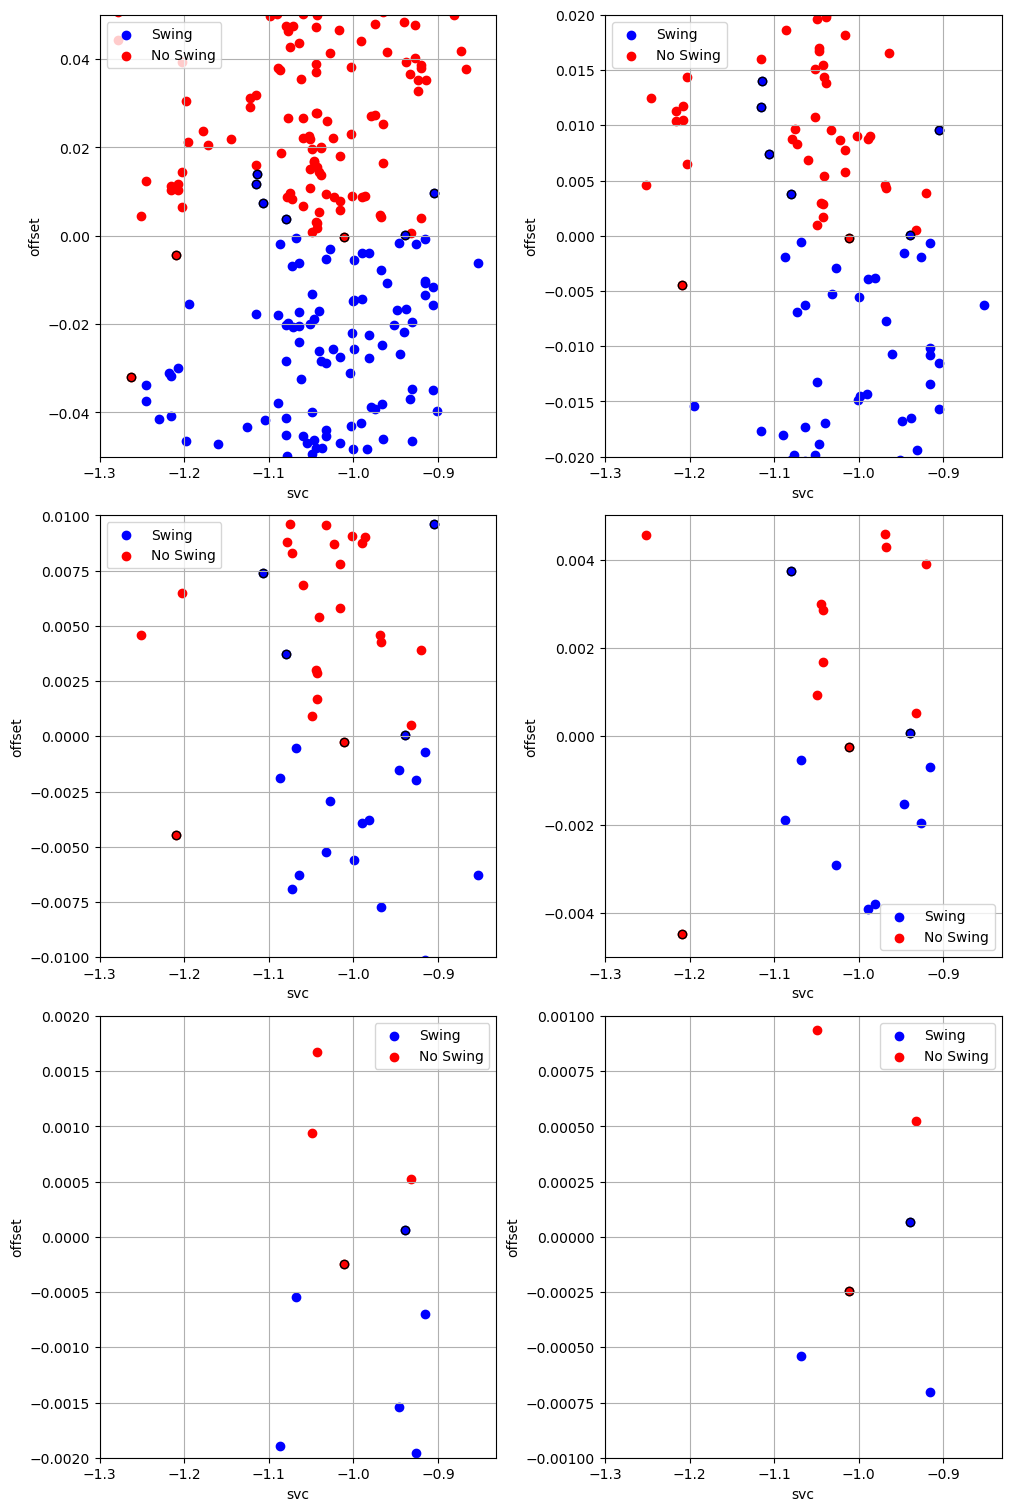

In [1061]:
x_val = "svc"
fig, axes = plt.subplots(3, 2, figsize=(10, 15), layout="constrained")
dimlist = [5e-2, 2e-2, 1e-2, 0.5e-2, 0.2e-2, 0.1e-2]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Swing",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="No Swing",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    # ax.set_yscale("log")
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig("../figures/swing_strike_fit_offsets.png", facecolor='white')

In [1029]:
# print(dfc[(~dfc["passed"]) & (dfc["roll"] < 0.1)]["svc"])
# dfc.loc[16149,[
#         "passed",
#         "offset",
#         # "event_type",
#         # "weather",
#         # "batter_laserlikeness",
#         "roll",
#         # "roll_pow",
#         "threshold",
#         "svc",
#         # "ruth",
#         "mox_vibes",
#         "ruth_vibes",
#         "path_scaled",
#         "viscosity",
#         "combined",
#         # "combined_batting",
#         # "combined_batting_0.5",
#         # "combined_batting_1.25",
#         # "combined_batting_0.25",
#         # "pitcher_multiplier",
#         # "batter_multiplier",
#         "batter_name",
#         "pitcher_name",
#         "batter_mods",
#         "pitcher_mods",
#         "batting_team_mods",
#         "pitching_team_mods",
#         "season",
#         "day",
#         "game_id",
#         "play_count",
#         # "batter_vibes"
#         # "fielder_roll",
#     ]]

In [1030]:
# print(dfc["combined"].min())
# print(dfc["combined"].argmin())
# print(dfc.loc[:, [
#     "passed",
#     "offset",
#     "roll",
#     "threshold",
#     # "ruth_scaled",
#     # "mox_scaled",
#     "path_scaled",
#     "viscosity",
#     # "combined",
#     # "combined_pow",
#     # "pitcher_multiplier",
#     # "batter_multiplier",
#     "batter_name",
#     "pitcher_name",
#     "batter_mods",
#     "pitcher_mods",
#     "batting_team_mods",
#     "pitching_team_mods",
#     "season",
#     "day",
#     "game_id",
#     "play_count",
#     "weather",
#     "batter_vibes",
#     "pitcher_vibes"
#     ]].iloc[dfc["combined"].argmin()])

(0.0, 0.75)

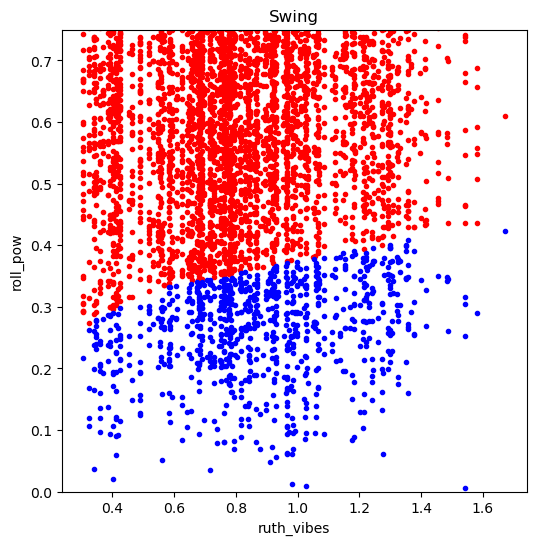

In [1091]:
x_val = "ruth_vibes"
y_val = "roll_pow"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[(~dfc["passed"]) & (dfc["roll"] > 0.1)][x_val],
    dfc[(~dfc["passed"]) & (dfc["roll"] > 0.1)][y_val],
    color="red",
    label="No Swing",
    marker='.',
)
ax.scatter(
    dfc[(dfc["passed"]) & (dfc["roll"] > 0.1)][x_val],
    dfc[(dfc["passed"]) & (dfc["roll"] > 0.1)][y_val],
    color="blue",
    label="Swing",
    marker='.',
)
# ax.plot(ax.get_xlim(), ax.get_xlim())



ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.set_title(f"Swing")
ax.set_ylim(0, 0.75)
# # ax.set_xlim(-3, 0)

In [807]:
# dfc["combined"].describe()

In [808]:
# x_val = "combined_log"
# y_val = "roll_log"
# fig, ax = plt.subplots(1, figsize=(6, 6))
# ax.scatter(
#     dfc[dfc["passed"]][x_val],
    # dfc[dfc["passed"]][y_val],
#     color="blue",
#     label="Swing",
#     marker='.',
# )

# ax.scatter(
#     dfc[~dfc["passed"]][x_val],
#     dfc[~dfc["passed"]][y_val],
#     color="red",
#     label="No Swing",
#     marker='.',
# )


# ax.set_xlabel(x_val)
# ax.set_ylabel(y_val)
# ax.set_title(f"Swing")
# ax.set_ylim(-3, 0)
# ax.set_xlim(-3, 0)

# # if x_val == "threshold":
# ax.plot(ax.get_xlim(), np.array(ax.get_xlim())*1.5, 'k', label="y = 1.5*x")

# ax.legend(loc="upper left")
# # fig.savefig("../figures/swing_balls_log.png", facecolor="white")

In [809]:
# print(dfc["combined"].argmin())
# print(dfc.iloc[dfc["combined"].argmin(), :])
# # print(dfc["offset"].iloc[dfc["combined"].argmin()])